To create an anaconda env to run this code:

```
$ conda create -n demo pandas requests matplotlib jupyter pyyaml
```

In [1]:
%matplotlib inline

import datetime
import requests
import pandas as pd
import yaml
import matplotlib

from dateutil.parser import parse

matplotlib.rcParams["axes.formatter.useoffset"] = False
matplotlib.rcParams["figure.figsize"] = (20, 10)
matplotlib.rcParams["legend.fontsize"] = "x-large"
matplotlib.rcParams["axes.labelsize"] = "x-large"
matplotlib.rcParams["axes.titlesize"] = "x-large"
matplotlib.rcParams["xtick.labelsize"] = "x-large"
matplotlib.rcParams["ytick.labelsize"] = "x-large"

The YML config file contains the target host and the API credentials. For example:

```
url: https://ooinet-dev-01.oceanobservatories.org
apiname: OOIAPI-XXXXXXXXXXX
apikey: XXXXXXXXXXXX
```

In [2]:
config = yaml.load(open('config_prod.yml'))
ntp_diff = (datetime.datetime(1970, 1, 1) - datetime.datetime(1900, 1, 1)).total_seconds()

These are some helper functions to transform an OOI JSON response into a pandas dataframe.

In [3]:
def clean_time(t):
    if isinstance(t, basestring):
        t = parse(t)
    t = t.replace(microsecond=0)
    return t.isoformat() +  '.000Z'

def clean_params(params):
    if 'parameters' in params:
        parameters = params['parameters']
        if isinstance(parameters, basestring):
            parameters = {int(p) for p in parameters.split(',')}
        elif isinstance(parameters, (list, tuple)):
            parameters = set(parameters)
        elif isinstance(parameters, int):
            parameters = {parameters}
        
        parameters.add(7)
        params['parameters'] = ','.join((str(p) for p in parameters))
    
    if 'beginDT' in params:
        params['beginDT'] = clean_time(params['beginDT'])
        
    if 'endDT' in params:
        params['endDT'] = clean_time(params['endDT'])
        
    if 'limit' not in params:
        params['limit'] = 2000
        
    return params
    
def get_data(subsite, node, sensor, method, stream, **params):
    url = '{host_url}/api/m2m/12576/sensor/inv/{subsite}/{node}/{sensor}/{method}/{stream}'.format(
        host_url=config['url'],
        subsite=subsite,
        node=node,
        sensor=sensor,
        method=method,
        stream=stream
    )
    params = clean_params(params)
        
    data = requests.get(url, params=params, auth=(config['apiname'], config['apikey'])).json()
    return data

def get_dataframe(subsite, node, sensor, method, stream, **params):
    data = get_data(subsite, node, sensor, method, stream, **params)
    df = pd.DataFrame(data)
    del df['pk']
    df['time'] = pd.to_datetime(df.time - ntp_diff, unit='s')
    df = df.set_index(df.time)
    del df['time']
    for p in df:
        if 'qc' in p:
            del df[p]
    return df

## Issue #4390 - Unable to calculate dissolved oxygen from surface mounted DOSTA

Note, this fix has already been deployed to production.

In [4]:
subsite, node, sensor = 'GA01SUMO-SBD11-04-DOSTAD000'.split('-', 2)
method, stream = 'telemetered', 'dosta_abcdjm_dcl_instrument'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=4000,
                   parameters=14,
                   beginDT='2016-12-01',
                   endDT='2016-12-11'
                   )

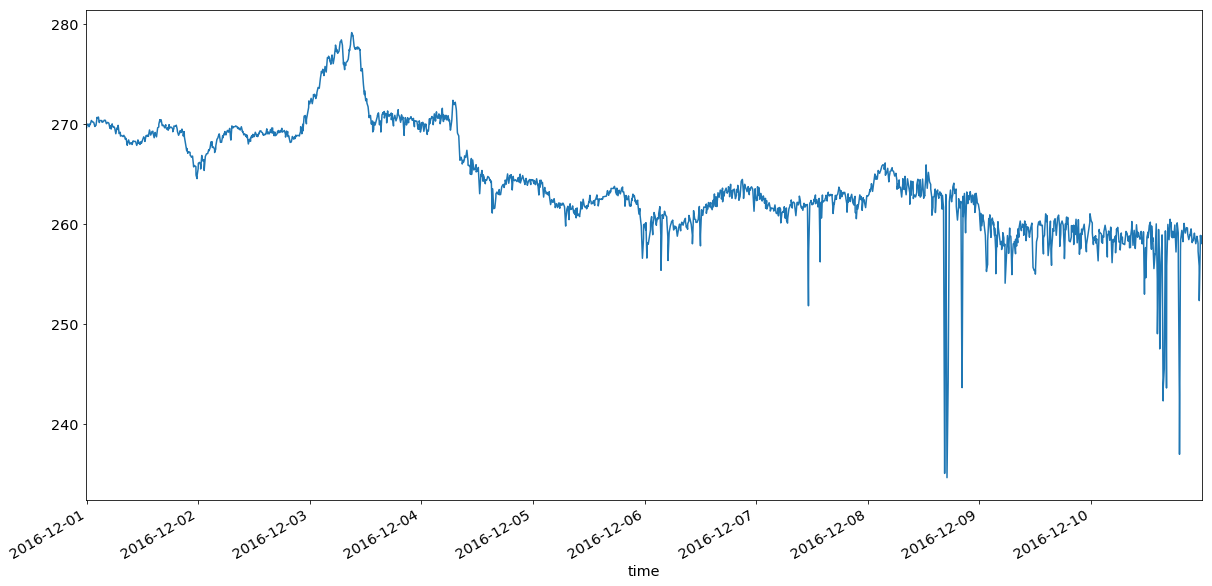

In [5]:
df.dissolved_oxygen.plot()

## Issue #3386 BOTPT compass lookup function has no default value, results in blowing up during execution

In [6]:
subsite, node, sensor = 'RS03CCAL-MJ03F-05-BOTPTA301'.split('-', 2)
method, stream = 'streamed', 'botpt_lily_sample'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=1000,
                   parameters=(1133,312),
                   beginDT='2014-09-01 05:30:50',
                   endDT='2014-09-01 05:31:00'
                   )

In [7]:
df

,corrected_compass_direction,serial_number
time,,
2014-09-01 05:30:50,-9999999.0,N9676
2014-09-01 05:30:51,-9999999.0,N9676
2014-09-01 05:30:52,-9999999.0,N9676
2014-09-01 05:30:53,-9999999.0,N9
2014-09-01 05:30:54,-9999999.0,N9676
2014-09-01 05:30:55,-9999999.0,N9676
2014-09-01 05:30:56,-9999999.0,N9676
2014-09-01 05:30:57,-9999999.0,N9676
2014-09-01 05:30:58,-9999999.0,N9676


In [8]:
subsite, node, sensor = 'RS03CCAL-MJ03F-05-BOTPTA301'.split('-', 2)
method, stream = 'streamed', 'botpt_lily_sample'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=1000,
                   parameters=(1133,312),
                   beginDT='2014-09-01 05:31:00',
                   endDT='2014-09-01 05:31:10'
                   )

In [9]:
df

,corrected_compass_direction,serial_number
time,,
2014-09-01 05:31:00,345.0,N9676
2014-09-01 05:31:01,345.0,N9676
2014-09-01 05:31:02,345.0,N9676
2014-09-01 05:31:03,345.0,N9676
2014-09-01 05:31:04,345.0,N9676
2014-09-01 05:31:05,345.0,N9676
2014-09-01 05:31:06,345.0,N9676
2014-09-01 05:31:07,345.0,N9676
2014-09-01 05:31:08,345.0,N9676


## Issue #8655 CTD seawater_pressure data off by 50 dbar

In [10]:
subsite, node, sensor = 'RS03AXBS-LJ03A-12-CTDPFB301'.split('-', 2)
method, stream = 'streamed', 'ctdpf_optode_sample'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=4000,
                   parameters=909,
                   beginDT='2016-07-01 00:00:00',
                   endDT='2016-08-01 00:00:10'
                   )

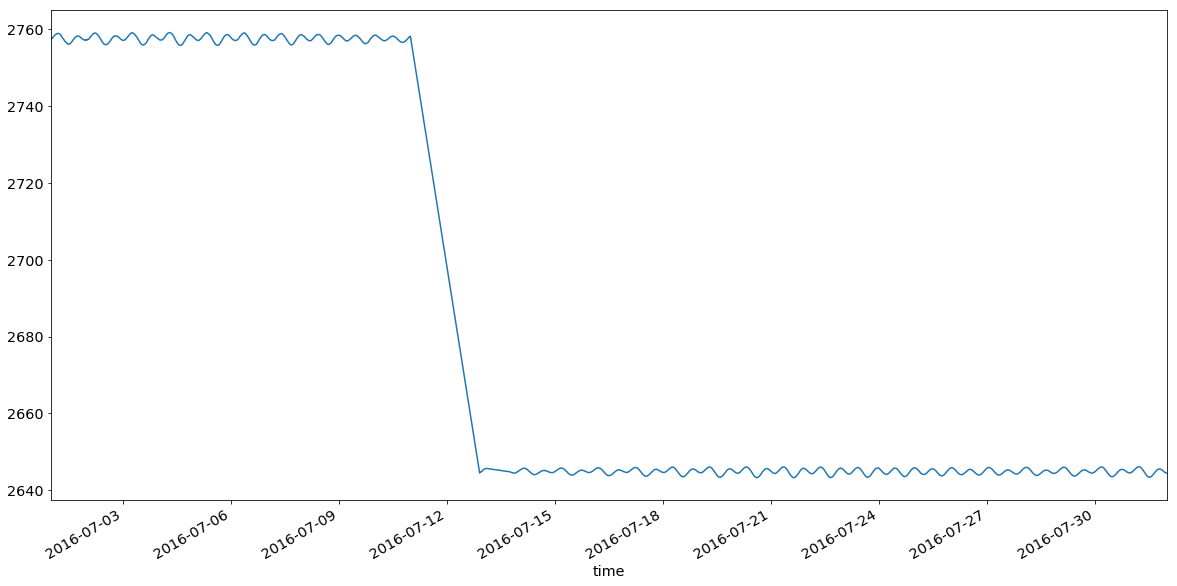

In [11]:
df.seawater_pressure.plot()

## Issue #12060 GI01SUMO-SBD12-06-METBKA000_R00001 metbk_a_dcl_instrument_recovered parameters are records of NaNs

In [12]:
subsite, node, sensor = 'GI01SUMO-SBD12-06-METBKA000'.split('-', 2)
method, stream = 'telemetered', 'metbk_a_dcl_instrument'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=40,
                   parameters=(3070,3071,3072),
                   beginDT='2016-07-11 00:00:00',
                   endDT='2016-07-12 00:00:00'
                   )

In [13]:
df.head()

,met_current_direction,met_current_speed,met_relwind_direction
time,,,
2016-07-11 00:00:46.119,NaN,NaN,NaN
2016-07-11 01:50:45.494,NaN,NaN,NaN
2016-07-11 03:04:49.893,NaN,NaN,NaN
2016-07-11 03:41:55.780,NaN,NaN,NaN
2016-07-11 04:18:58.865,NaN,NaN,NaN


## Issue #12125 presf-abc-tide-measurement-recovered has incorrect parameter mapping

In [14]:
subsite, node, sensor = 'CE07SHSM-MFD35-02-PRESFB000'.split('-', 2)
method, stream = 'telemetered', 'presf_abc_dcl_tide_measurement'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=4000,
                   parameters=(742,3250),
                   beginDT='2016-05-06 00:00:00',
                   endDT='2016-05-15 00:00:00'
                   )

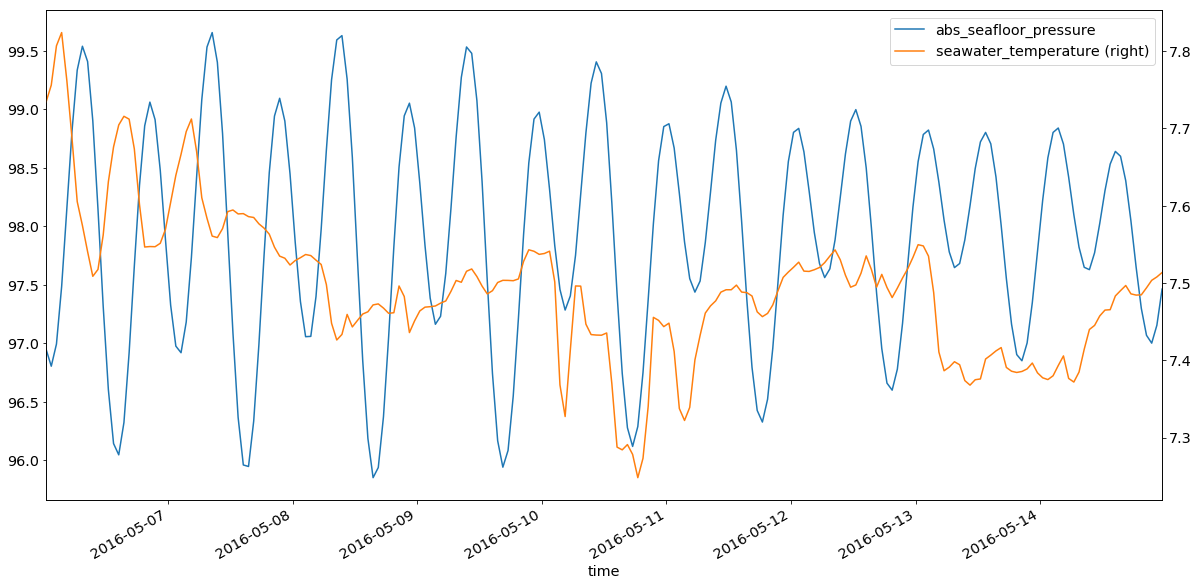

In [15]:
df.plot(secondary_y='seawater_temperature')

## Issue #12136 PD2750 (sci_abs_oxygen) using incorrect pressure input

In [16]:
subsite, node, sensor = 'CE05MOAS-GL381-04-DOSTAM000'.split('-', 2)
method, stream = 'recovered_host', 'dosta_abcdjm_glider_recovered'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=4000,
                   parameters=2750,
                   beginDT='2014-12-13 00:00:00',
                   endDT='2014-12-13 06:00:00'
                   )

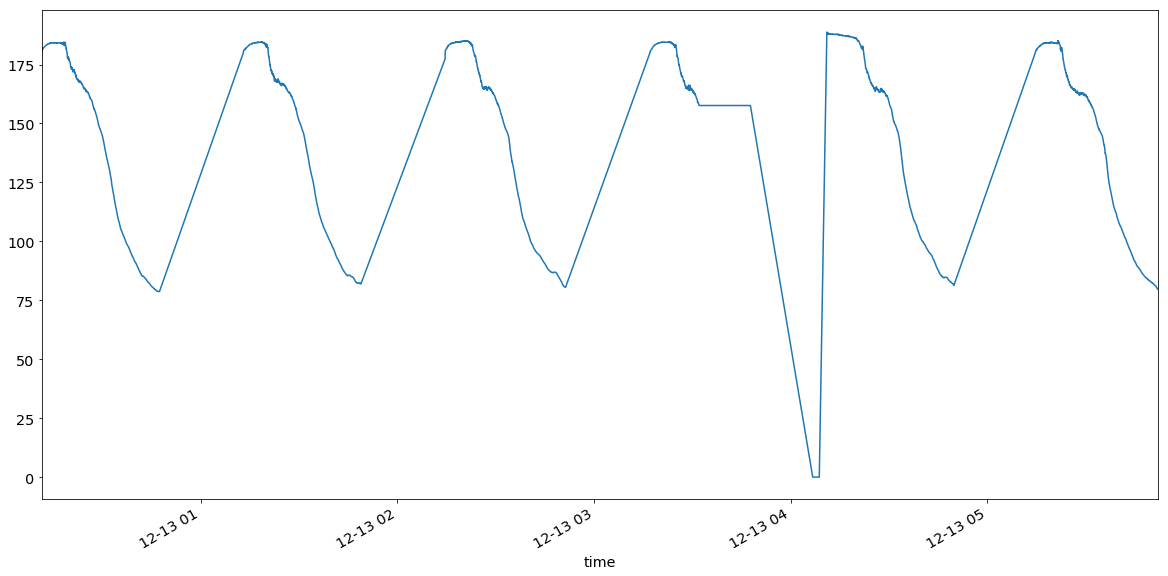

In [17]:
df.sci_abs_oxygen.plot()

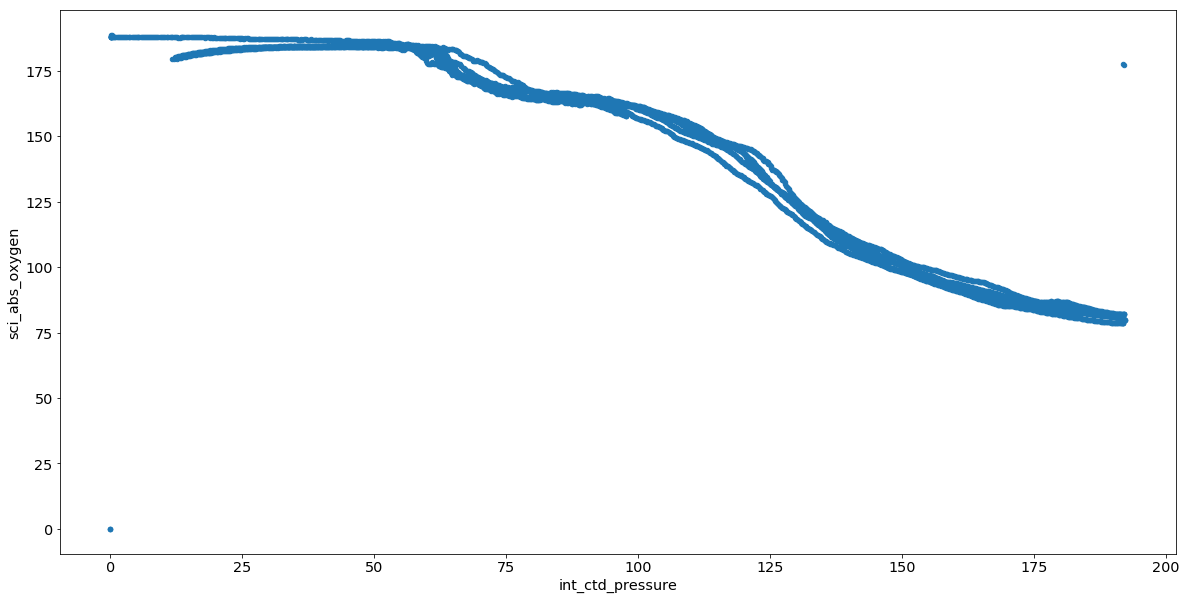

In [18]:
df.plot.scatter(x='int_ctd_pressure', y='sci_abs_oxygen')

## Issue #9113 PCO2W - pCO2 in Water values outside global ranges

In [19]:
subsite, node, sensor = 'CE04OSPS-PC01B-4C-PCO2WA105'.split('-', 2)
method, stream = 'streamed', 'pco2w_a_sami_data_record'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=4000,
                   parameters=3729,
                   beginDT='2016-07-03 00:00:00',
                   endDT='2016-07-10 00:00:00'
                   )

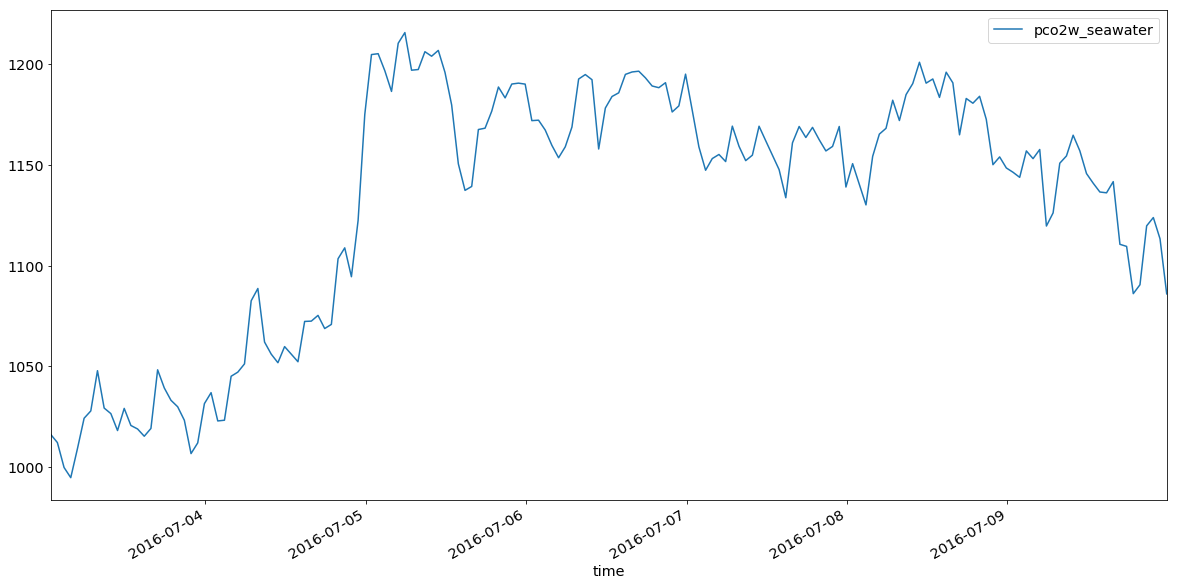

In [20]:
df.plot()

## Issue #12215 UI plotting downsampling routine appears to generate a data gap where there is none


In [21]:
subsite, node, sensor = 'RS03CCAL-MJ03F-05-BOTPTA301'.split('-', 2)
method, stream = 'streamed', 'botpt_nano_sample'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=2000,
                   parameters=848,
                   beginDT='2017-03-04 00:00:00',
                   endDT='2017-03-04 01:00:00'
                   )

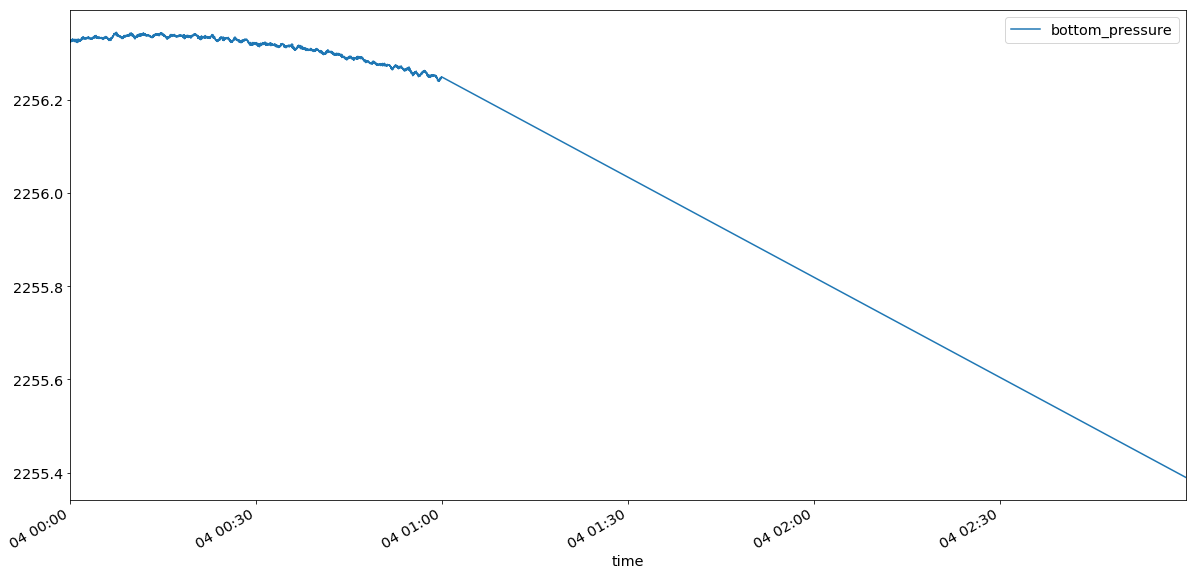

In [22]:
df.plot()